## Work
1. 請比較使用 l1, l1_l2 及不同比例下的訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.regularizers import l1, l2, l1_l2

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l1_ratio=0, l2_ratio=0):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            if l1_ratio==0 and l2_ratio==0:
                pass
            if l1_ratio!=0 and l2_ratio==0:
                x = keras.layers.Dense(units=n_units, 
                                       activation="relu", 
                                       name="hidden_layer"+str(i+1), 
                                       kernel_regularizer=l1(l1_ratio))(input_layer)
            if l1_ratio==0 and l2_ratio!=0:
                x = keras.layers.Dense(units=n_units, 
                                       activation="relu", 
                                       name="hidden_layer"+str(i+1), 
                                       kernel_regularizer=l2(l2_ratio))(input_layer)
            if l1_ratio!=0 and l2_ratio!=0:
                x = keras.layers.Dense(units=n_units, 
                                       activation="relu", 
                                       name="hidden_layer"+str(i+1), 
                                       kernel_regularizer=l1_l2(l1=l1_ratio, l2=l2_ratio))(input_layer)
        else:
            if l1_ratio==0 and l2_ratio==0:
                pass
            if l1_ratio!=0 and l2_ratio==0:
                x = keras.layers.Dense(units=n_units, 
                                       activation="relu", 
                                       name="hidden_layer"+str(i+1), 
                                       kernel_regularizer=l1(l1_ratio))(x)
            if l1_ratio==0 and l2_ratio!=0:
                x = keras.layers.Dense(units=n_units, 
                                       activation="relu", 
                                       name="hidden_layer"+str(i+1), 
                                       kernel_regularizer=l2(l2_ratio))(x)
            if l1_ratio!=0 and l2_ratio!=0:
                x = keras.layers.Dense(units=n_units, 
                                       activation="relu", 
                                       name="hidden_layer"+str(i+1), 
                                       kernel_regularizer=l1_l2(l1=l1_ratio, l2=l2_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
L1_EXP = [0, 1e-4, 1e-8]
L2_EXP = [0, 1e-4, 1e-8]

In [7]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for regulizer_ratio_1 in L1_EXP:
    for regulizer_ratio_2 in L2_EXP:
        if regulizer_ratio_1!=0 and regulizer_ratio_2!=0:
            keras.backend.clear_session() # 把舊的 Graph 清掉
            #print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
            model = build_mlp(input_shape=x_train.shape[1:], l1_ratio=regulizer_ratio_1, l2_ratio=regulizer_ratio_2)
            model.summary()
            optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
            model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

            model.fit(x_train, y_train, 
                      epochs=EPOCHS, 
                      batch_size=BATCH_SIZE, 
                      validation_data=(x_test, y_test), 
                      shuffle=True)

            # Collect results
            train_loss = model.history.history["loss"]
            valid_loss = model.history.history["val_loss"]
            train_acc = model.history.history["acc"]
            valid_acc = model.history.history["val_acc"]

            exp_name_tag = "l1:{}_l2:{}".format(regulizer_ratio_1, regulizer_ratio_2)
            results[exp_name_tag] = {'train-loss': train_loss,
                                     'valid-loss': valid_loss,
                                     'train-acc': train_acc,
                                     'valid-acc': valid_acc}

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 20s 399us/step - loss: 6

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 8s 157us/step - loss: 5.9984 - acc: 0.2767 - val_loss: 5.7958 - val_acc: 0.3532
Epoch 2/50
50000/50000 [==============================] - 7s 144us/step - loss: 5.6990 - acc: 0.3719 - val_loss: 5.6249 - val_acc: 0.3883
Epoch 3/50
50000/50000 [==============================] - 7s 144us/step - loss: 5.5555 - acc: 0.4020 - val_loss: 5.4973 - val_acc: 0.4130
Epoch 4/50
50000/50000 [==============================] - 7s 144us/step - loss: 5.4359 - acc: 0.4214 - val_loss: 5.3998 - val_acc: 0.4190
Epoch 5/50
50000/50000 [==============================] - 7s 144us/step - loss: 5.3271 - acc: 0.4394 - val_loss: 5.2992 - val_acc: 0.4237
Epoch 6/50
50000/50000 [==============================] - 7s 144us/step - loss: 5.2290 - acc: 0.4503 - val_loss: 5.2006 - val_acc: 0.4433
Epoch 7/50
50000/50000 [==============================] - 7s 143us/step - loss: 5.1355 - acc: 0.4611 - val_loss: 5.1084 - 

50000/50000 [==============================] - 7s 144us/step - loss: 1.9298 - acc: 0.3684 - val_loss: 1.8785 - val_acc: 0.3858
Epoch 3/50
50000/50000 [==============================] - 7s 142us/step - loss: 1.8472 - acc: 0.3995 - val_loss: 1.8178 - val_acc: 0.4066
Epoch 4/50
50000/50000 [==============================] - 7s 143us/step - loss: 1.7911 - acc: 0.4184 - val_loss: 1.7660 - val_acc: 0.4283
Epoch 5/50
50000/50000 [==============================] - 7s 144us/step - loss: 1.7460 - acc: 0.4363 - val_loss: 1.7437 - val_acc: 0.4242
Epoch 6/50
50000/50000 [==============================] - 7s 145us/step - loss: 1.7085 - acc: 0.4482 - val_loss: 1.7096 - val_acc: 0.4398
Epoch 7/50
50000/50000 [==============================] - 7s 143us/step - loss: 1.6749 - acc: 0.4615 - val_loss: 1.6792 - val_acc: 0.4588
Epoch 8/50
50000/50000 [==============================] - 7s 144us/step - loss: 1.6452 - acc: 0.4692 - val_loss: 1.6561 - val_acc: 0.4622
Epoch 9/50
50000/50000 [=====================

50000/50000 [==============================] - 7s 142us/step - loss: 1.7153 - acc: 0.3990 - val_loss: 1.6879 - val_acc: 0.4113
Epoch 4/50
50000/50000 [==============================] - 7s 142us/step - loss: 1.6544 - acc: 0.4196 - val_loss: 1.6358 - val_acc: 0.4261
Epoch 5/50
50000/50000 [==============================] - 7s 142us/step - loss: 1.6074 - acc: 0.4351 - val_loss: 1.6014 - val_acc: 0.4380
Epoch 6/50
50000/50000 [==============================] - 7s 142us/step - loss: 1.5682 - acc: 0.4511 - val_loss: 1.5596 - val_acc: 0.4486
Epoch 7/50
50000/50000 [==============================] - 7s 142us/step - loss: 1.5363 - acc: 0.4606 - val_loss: 1.5339 - val_acc: 0.4623
Epoch 8/50
50000/50000 [==============================] - 7s 142us/step - loss: 1.5074 - acc: 0.4715 - val_loss: 1.5172 - val_acc: 0.4619
Epoch 9/50
50000/50000 [==============================] - 7s 142us/step - loss: 1.4824 - acc: 0.4786 - val_loss: 1.5098 - val_acc: 0.4681
Epoch 10/50
50000/50000 [====================

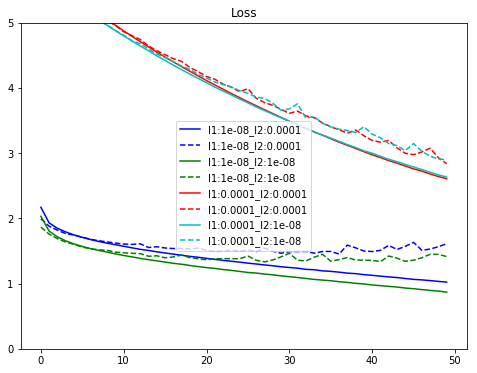

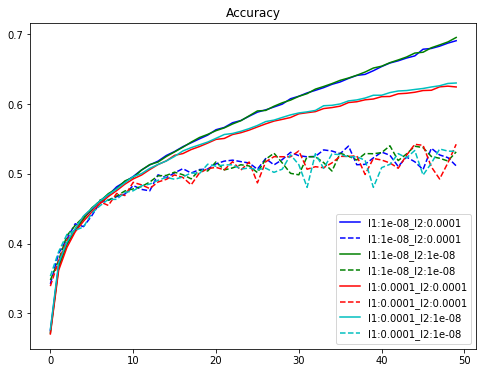

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
color_bar = ["b", "g", "r", "c", "m", "y", "k", "#33FFCE"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()